## Ensemble refinement for pH

Tools for the refinement of systems with observables measured at different pH values.

Ensemble refinement only.

This will be implemented as a module `ph_refine` of the Python package `MDRefine`

### Theory (loss function)

\begin{equation}
\mathcal L (\{ P_j\}, \vec\pi) =
\frac{1}{2}\sum_{k=1}^{N_{obs}}\sum_{\substack{i=1\\i\in \sigma(k)}}^{N_{ph}} \Bigl( \frac{\sum_j w_{ij} \langle g_k \rangle_{P_j} - g_{ik,exp}}{\sigma_{ik,exp}}\Bigr)^2 + \sum_j \alpha_j D_{KL}[P_j||P_{0j}] + \alpha D_{KL}[\vec\pi | \vec \pi_0]
\tag{1}
\end{equation}

with normalization of $P_j(x)$, $\vec\pi$ and $w_{ij}$ (the relation between $w_{ij}$ and $\pi_j$ is given by the grand-canonical ensemble; also $\alpha_j$ might depend on $\vec\pi$, for example as $\alpha_j = \alpha \pi_j$, but perhaps it has more physical meaning to keep all them $\alpha_j = \alpha$).

Minimizing this loss function over the ensembles $P_j$ is equivalent to maximize the following loss function (same spirit of $\tilde\Gamma$) over the $\vec\lambda$ coefficients (one for each $g_{exp}$ value, independently on the number of protonation states $\#\{P_j\}$):

\begin{equation}
\begin{split}
\tilde{\mathcal L} (\vec\lambda, \vec\pi) & 
= -\sum_k \sum_{i, i\in \sigma(k)} \Bigl( \frac{1}{2} \sigma_{ki,exp}^2 \lambda_{ki}^2 + \lambda_{ki} g_{ki,exp} \Bigr) - \sum_j \log Z_j(\vec\lambda, \vec\pi) + \alpha D_{KL}[\vec\pi || \vec\pi_0] \\
& = - \Gamma(\vec\lambda;\vec\pi) + \alpha D_{KL}[\vec\pi || \vec\pi_0]
\tag{2}
\end{split}
\end{equation}

where the ensemble $P_j$ is parametrized by $\lambda$ as

\begin{equation}
P_j(x;\vec\lambda) = \frac{1}{Z_j(\vec\lambda)} P_{0j}(x) \, \mathrm{exp}\Bigl\{-\frac{1}{\alpha_j} \sum_k \sum_{i,i\in\sigma(k)} \lambda_{ki} w_{ij} g_k(x) \Bigr\}.
\tag{3}
\end{equation}

Notice the $\vec\lambda$ coefficients are present according with the experimental values, not with the structural (protonation) ensembles $P_j$.

This simplifies to our usual case, in which we have experimental values corresponding to same pH value (but different molecular systems).

### Main functions

In [1]:
import jax.numpy as np
import numpy as numpy

In [2]:
class Manage_indices():
    """
    Manage experimental value indices relative to observable and pH indices.

    This class relies both on `numpy` and `jax.numpy` because of filling matrices, which is not plainly
    allowed in Jax.

    This class provides utility methods for working with a 2D matrix of experimental values for example
    (`my_exp_values`), where:
    * The **first index** corresponds to the observable index.
    * The **second index** corresponds to the pH index.

    ### Methods
    - **build_legend(my_exp_values)** → `(legend_matrix, legend_row)`  
    Builds:
    - `legend_matrix`: a 2D array where each element stores the index of the corresponding
        value in a flattened list (`-1` if the value is absent).  
    - `legend_row`: a 1D array storing the ending index of each observable row in the flattened data.  

    - **flatten(my_exp_values)** → `flat_mat`  
    Flattens `my_exp_values` into a 1D array of non-NaN values according to `legend_matrix`.  

    - **flat_to_matrix(flat_mat, legend_matrix)** → `my_exp_values`  
    Reconstructs the original `my_exp_values` matrix from its flattened form and the legend.  

    ### Example
    ```python
    my_exp_values = np.array([
        [0.1, 0.2, 0.1, np.nan, np.nan],
        [np.nan, 0.4, 0.5, np.nan, 0.7],
        [np.nan, np.nan, np.nan, 0.2, np.nan],
        [0.3, 0.5, 0.8, np.nan, 0.1],
        [np.nan, np.nan, 0.3, 0.3, np.nan]
    ])

    # Build legend
    legend_matrix, legend_row = ManageIndices.build_legend(my_exp_values)

    # Flatten and reconstruct
    flat_mat = ManageIndices.flatten(my_exp_values)
    mat = ManageIndices.flat_to_matrix(flat_mat, legend_matrix)

    # Select values for a specific observable (row i)
    i = 3
    values_for_obs = flat_mat[legend_row[i] : legend_row[i + 1]]

    # Example usage in a correction computation:
    correction_lambdas = (1 / alphas[j]) * np.einsum(
        'ki,ij,kt->jt',
        lambdas[legend_row[i] : legend_row[i + 1]],
        ph_weights[j],
        g
    )
    ```

    This workflow is useful for handling non-trivial sums over observable and pH indices when
    a simple 1D representation of lambdas is insufficient.
    """
    def build_legend(my_exp_values):
        a, b = my_exp_values.shape

        legend_matrix = numpy.full((a, b), 0)
        legend_row = [0]

        tot = 0

        for i in range(a):
            for j in range(b):
                if not np.isnan(my_exp_values[i, j]):
                    legend_matrix[i, j] = tot
                    tot += 1
                else:
                    legend_matrix[i, j] = -1

            legend_row.append(tot)

        legend_matrix = np.int32(legend_matrix)
        legend_row = np.int32(legend_row)

        return legend_matrix, legend_row

    def flatten(my_exp_values):
        flat_mat = np.ravel(my_exp_values)
        flat_mat = flat_mat[~np.isnan(flat_mat)]
        return flat_mat

    def flat_to_matrix_old(flat_mat, legend_matrix):
        """ It uses also NumPy, not only Jax """

        mat = numpy.full(legend_matrix.shape, np.nan)

        whs = np.argwhere(legend_matrix >= 0)
        for wh in whs: mat[wh[0], wh[1]] = flat_mat[legend_matrix[wh[0], wh[1]]]

        mat = np.array(mat)

        return mat
    
    def flat_to_matrix(flat_mat, legend_matrix):
        """
        Reconstructs a matrix from its flattened representation and legend_matrix,
        using only JAX (no Python-side assignments).
        """

        # Initialize with NaNs
        mat = np.full(legend_matrix.shape, np.nan)

        # Indices where legend_matrix >= 0
        whs = np.argwhere(legend_matrix >= 0)

        # Values to insert: flat_mat[legend_matrix[idx]]
        vals = flat_mat[legend_matrix[whs[:, 0], whs[:, 1]]]

        # Update using JAX's immutable update API
        mat = mat.at[whs[:, 0], whs[:, 1]].set(vals)

        return mat

In [3]:
import MDRefine
from MDRefine import compute_new_weights

In [4]:
def ph_gamma(lambdas, legend_matrix, gs, g_exp, weights_ref, alphas, ph_weights):
    """
    Compute the Gamma function for the pH refinement.

    Parameters:
    ----------
    
    lambdas : 1-D array-like
        Numpy 1-dimensional array, each element corresponds to the lambda value for an experimental observable
        at a certain pH value; this correspondence is given by `Manage_indices.flatten` (from table of values
        to 1d array) and `Manage_indices.flat_to_matrix` (from 1d array to table of values).
    
    legend_matrix :
        Numpy 2-dimensional array used to map `lambdas` 1d array into the table of values by
        `Manage_indices.flat_to_matrix` (first index is for the observable, second index for the pH).

    gs : List of 2-D array-like
        List (one element for each protonation state) of Numpy 2-dimensional arrays (M x N);
        `g[i, j]` is the j-th observable computed in the i-th frame.
    
    g_exp : 2-D array-like
        Numpy 2-dimensional array (N x 2); `g_exp[j, 0]` is the experimental value of the j-th observable,
        `g_exp[j,1]` is the associated experimental uncertainty.
    
    weights_ref : List of 1-D array-like
        List (one element for each protonation state) of Numpy 1-dimensional arrays, each of them is the
        set of weights for the reference ensemble.
    
    alphas : 1-D array-like
        Numpy 1-dimensional array for the values of the alpha hyperparameters.
    
    ph_weights : 2-D array-like
        Numpy 2-dimensional array, `ph_weights[i, j]` is the probability of the protonation state `j` at pH `i`,
        normalized over `j` for every `i`.

    Return
    ----------

    gamma : float
        Value of the pH_Gamma function (analogous to the Gamma function for the pH application).
    """
    # if len(alphas) == 1:
    # then just a single hyperparameter alpha (so, optimize over a single hyperparameter)
    logZs = []
    
    n_ph = len(weights_ref)

    table_lambdas = Manage_indices.flat_to_matrix(lambdas, legend_matrix)
    table_lambdas = np.nan_to_num(table_lambdas)  # put nan to zero
    
    for j in range(n_ph):
        # print(fake_lambdas.shape, ph_weights.shape, gs[j].shape)
        # print(np.einsum('ki,i,lk', fake_lambdas, ph_weights[:, j], gs[j]))
        correction_lambdas = 1/alphas[j]*np.einsum('ki,i,tk->t', table_lambdas, ph_weights[:, j], gs[j])
        log_Z_lambda = compute_new_weights(weights_ref[j], correction_lambdas)[1]
        logZs.append(log_Z_lambda)

    logZs = np.array(logZs)
    
    gamma = 1/2*np.sum((lambdas*g_exp[:, 1])**2) + np.dot(lambdas, g_exp[:, 0]) + np.sum(logZs)

    return gamma

### Simple cases of usage of the main functions

In [3]:
my_exp_values = np.array([[0.1, 0.2, 0.1, np.nan, np.nan], [np.nan, 0.4, 0.5, np.nan, 0.7],
                 [np.nan, np.nan, np.nan, 0.2, np.nan], [0.3, 0.5, 0.8, np.nan, 0.1],
                 [np.nan, np.nan, 0.3, 0.3, np.nan]])

print(my_exp_values)

# so the first index in my_exp_values corresponds to the observable index, and the second to the ph index
legend_matrix, legend_row = Manage_indices.build_legend(my_exp_values)

print(legend_matrix, legend_row)

flat_mat = Manage_indices.flatten(my_exp_values)

print(flat_mat)

mat = Manage_indices.flat_to_matrix(flat_mat, legend_matrix)

mat

[[0.1 0.2 0.1 nan nan]
 [nan 0.4 0.5 nan 0.7]
 [nan nan nan 0.2 nan]
 [0.3 0.5 0.8 nan 0.1]
 [nan nan 0.3 0.3 nan]]
[[ 0  1  2 -1 -1]
 [-1  3  4 -1  5]
 [-1 -1 -1  6 -1]
 [ 7  8  9 -1 10]
 [-1 -1 11 12 -1]] [ 0  3  6  7 11 13]
[0.1 0.2 0.1 0.4 0.5 0.7 0.2 0.3 0.5 0.8 0.1 0.3 0.3]


Array([[0.1, 0.2, 0.1, nan, nan],
       [nan, 0.4, 0.5, nan, 0.7],
       [nan, nan, nan, 0.2, nan],
       [0.3, 0.5, 0.8, nan, 0.1],
       [nan, nan, 0.3, 0.3, nan]], dtype=float32, weak_type=True)

In [4]:
Manage_indices.flat_to_matrix_old(flat_mat, legend_matrix)

Array([[0.1, 0.2, 0.1, nan, nan],
       [nan, 0.4, 0.5, nan, 0.7],
       [nan, nan, nan, 0.2, nan],
       [0.3, 0.5, 0.8, nan, 0.1],
       [nan, nan, 0.3, 0.3, nan]], dtype=float32)

In [5]:
i = 3

flat_mat[legend_row[i] : legend_row[i + 1]]
# this is the array of values corresponding to the i-th observable at different pH values
# so that the correction is computed as 
# correction_lambdas = 1/alphas[j]*np.einsum('ki,ij,kt->jt', lambdas[legend_row[i] : legend_row[i + 1]], ph_weights[j], g)

Array([0.3, 0.5, 0.8, 0.1], dtype=float32)

In [8]:
print(flat_mat, legend_row)

n_exp_vals = len(flat_mat)

# The **first index** corresponds to the observable index, the **second index** corresponds to the pH index
n_obs, n_ph = my_exp_values.shape
n_prot = 2

lambdas = np.ones(n_exp_vals)

sigma_exp = 0.1*np.ones(n_exp_vals)

g_exp = np.stack((flat_mat, sigma_exp)).T

# ph_weights[i, j] tells how much protonation state j contributes at pH i
# so it is normalized over the protonation states (sum over j must be 1 for every i)
ph_weights = []
for i in range(n_ph):
    ph_w = np.ones(n_prot)
    ph_w /= np.sum(ph_w)
    ph_weights.append(ph_w)
ph_weights = np.array(ph_weights)

alphas = np.ones(n_ph)

weights_ref = []
gs = []

n_frames = [100, 150, 75, 129, 4]

assert len(n_frames) == n_ph, 'error on n_frames'

for i in range(n_ph):
    weights_ref.append(numpy.random.rand(n_frames[i]))
    gs.append(numpy.random.rand(n_frames[i], n_obs))


g_exp.shape

[0.1 0.2 0.1 0.4 0.5 0.7 0.2 0.3 0.5 0.8 0.1 0.3 0.3] [ 0  3  6  7 11 13]


(13, 2)

In [9]:
ph_gamma(lambdas, legend_matrix, gs, g_exp, weights_ref, alphas, ph_weights)

Array(-10.24052342, dtype=float64)

### Gradient of Gamma and minimization

In [ ]:
import jax
from scipy.optimize import minimize

In [ ]:
ph_gamma_gradient_fun = jax.grad(ph_gamma, argnums=0)

def ph_gamma_and_grad(lambdas, legend_matrix, gs, g_exp, weights_ref, alphas, ph_weights):
    args = (lambdas, legend_matrix, gs, g_exp, weights_ref, alphas, ph_weights)
    gamma = ph_gamma(*args)
    grad = ph_gamma_gradient_fun(*args)
    return gamma, grad

In [13]:
args = (lambdas, legend_matrix, gs, g_exp, weights_ref, alphas, ph_weights)

ph_gamma_gradient_fun(*args)

Array([-0.89620079, -0.79620078, -0.89620079, -0.48329854, -0.38329854,
       -0.18329856, -0.86773447, -0.80662741, -0.60662742, -0.30662741,
       -1.00662742, -0.65846141, -0.65846141], dtype=float64)

In [ ]:
args = (legend_matrix, gs, g_exp, weights_ref, alphas, ph_weights)

mini = minimize(ph_gamma_and_grad, lambdas, args=args, method='BFGS', jac=True)  # , options={'gtol': gtol})


In [19]:
ph_gamma(lambdas, *args)

Array(-9.76651757, dtype=float64)

In [17]:
mini

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -91.52374329652514
        x: [ 2.752e+01  1.752e+01 ...  4.343e+01  4.343e+01]
      nit: 41
      jac: [ 5.361e-06  4.801e-06 ... -2.000e-06 -2.000e-06]
 hess_inv: [[ 2.057e+01  1.864e+01 ...  2.576e+00  2.576e+00]
            [ 1.864e+01  2.145e+01 ...  2.100e+00  2.100e+00]
            ...
            [ 2.576e+00  2.100e+00 ...  2.596e+01  2.496e+01]
            [ 2.576e+00  2.100e+00 ...  2.496e+01  2.596e+01]]
     nfev: 44
     njev: 44

sanity check: $\min \Gamma$ is negative as it should be because it is the opposite of the loss function (which is always positive) in its minimum (a part from the KL term for the pH weights)

In [20]:
mini.x

array([ 27.51887624,  17.51882008,  27.51887624,  30.96435588,
        20.96430046,   0.96418962,  60.56810478,  29.01927541,
         9.01916457, -20.98100467,  49.01938849,  43.4309016 ,
        43.4309016 ])

In [21]:
new_lambdas = np.zeros(len(lambdas))

mini = minimize(ph_gamma_and_grad, new_lambdas, args=args, method='BFGS', jac=True)  # , options={'gtol': gtol})

mini

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -91.5237432980671
        x: [ 2.752e+01  1.752e+01 ...  4.343e+01  4.343e+01]
      nit: 42
      jac: [ 4.692e-06  4.287e-06 ... -1.730e-06 -1.730e-06]
 hess_inv: [[ 2.126e+01  1.960e+01 ...  3.817e+00  3.817e+00]
            [ 1.960e+01  2.290e+01 ...  3.846e+00  3.846e+00]
            ...
            [ 3.817e+00  3.846e+00 ...  2.657e+01  2.557e+01]
            [ 3.817e+00  3.846e+00 ...  2.557e+01  2.657e+01]]
     nfev: 44
     njev: 44

### Full loss function

\begin{equation}
w_{ij}(\vec\pi) = \frac{\pi_j \, e^{\beta\Delta\mu_i N_j}}{\sum_j \pi_j \, e^{\beta\Delta\mu_i N_j}}
\tag{4}
\end{equation}

where $e^{\beta\Delta\mu_i}$ is the fugacity factor for pH n. i ($\Delta\mu_i$)

\begin{equation}
\tilde{\mathcal L} (\vec\pi) = -\min_{\vec\lambda} \Gamma(\vec\lambda;\vec\pi) + \alpha D_{KL}[\vec\pi || \vec\pi_0]
\tag{5}
\end{equation}


- the constraint $\pi_i \geq 0$ can be imposed with a change of variable to the log weights $\pi_i = e^{\nu_i}$ (this excludes $\pi_i =0$ but we can go arbitrarily close so it's fine); then there is the constraint $\sum_i \pi_i = 1$; minimizing over $\pi_i$ can be casted to a minimization over $\nu_i$

In [ ]:
def compute_ph_weights_old(pi, fugacity, ns):
    # this if the first input variable is the weights and not their logarithm
    ph_weights = pi*fugacity**ns

    ph_weights /= np.sum(ph_weights)
    return ph_weights

def compute_ph_weights(log_pi, log_fugacity, ns):
    ph_weights = np.exp(log_pi + log_fugacity*ns)
    ph_weights /= np.sum(ph_weights)
    return ph_weights

In [ ]:
def ph_loss(log_pi_vec, log_pi_ref, alpha_pi, lambdas, legend_matrix, gs, g_exp, weights_ref, alphas, log_fugacities, n_prot=[0, 1], is_fixed=True):
    
    # 1. compute ph_weights from pi_vec (ph_weights is a 2d array, `ph_weights[i, j]` is the probability
    # of the protonation state `j` at pH `i`, normalized over `j` for every `i`)
    ph_weights = []

    for log_fug in log_fugacities:
        weights = compute_ph_weights(log_pi_vec, log_fug, n_prot)
        weights /= np.sum(weights)
        ph_weights.append(weights)
    
    ph_weights = np.array(ph_weights)
    
    # 2. minimize Gamma function at given ph_weights
    args = (legend_matrix, gs, g_exp, weights_ref, alphas, ph_weights)

    if not is_fixed:
        mini = minimize(ph_gamma_and_grad, lambdas, args=args, method='BFGS', jac=True)  # , options={'gtol': gtol})
        gamma = mini.fun
    else:
        gamma = ph_gamma(lambdas, *args)
    
    # 3. compute the loss value
    pi_vec = np.exp(log_pi_vec)
    pi_vec /= np.sum(pi_vec)
    
    dkl = np.sum(np.exp(log_pi_vec)*(log_pi_vec - log_pi_ref))
    loss = - gamma + alpha_pi*dkl

    return loss

In [45]:
ph_loss_gradient_fun = jax.grad(ph_loss, argnums=0)

In [ ]:
def ph_loss_and_grad(lambdas, legend_matrix, gs, g_exp, weights_ref, alphas, ph_weights):
    args = (pi_vec, ref_pi, alpha_pi, lambdas, legend_matrix, gs, g_exp, weights_ref, alphas, fugacities, n_prot, is_fixed):
    loss = ph_loss(*args)
    grad = ph_loss_gradient_fun(*args)
    return loss, grad

### Load data

In [5]:
import pandas
import matplotlib.pyplot as plt

In [7]:
path = 'Simulation-data/A5mer/'

ns = {}
gs = {}

for ph in [3.50, 4.00, 4.50]:
    ns[ph] = pandas.read_csv(path + 'A5mer_pH0%.2f.occ' % ph, header=None).iloc[:, 0]
    
    df = pandas.read_csv(path + 'COLVAR_REWEIGHT_0%.2f' % ph, header=3, sep=' ').iloc[:, :4]
    df.columns = ['time', 'chi', 'eRMSD', 'bias']
    gs[ph] = df

len(ns[3.5])

150000

<BarContainer object of 400 artists>

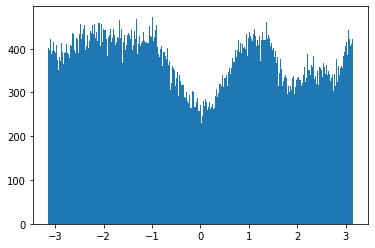

In [8]:
plt.hist(gs[3.5]['chi'], bins=400)[2]

(array([89862.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 60138.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

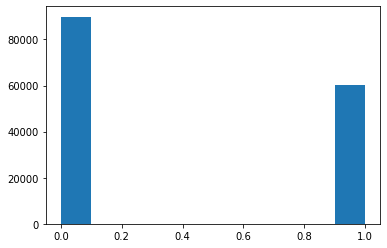

In [15]:
plt.hist(ns[4.5])

In [ ]:
ph_values = list(gs.keys())

# fake values (synthetic, then compute them by biasing initial time series)
g_exp = []
sigma_exp = []

for ph in ph_values:
    my_vals = np.array(gs[ph][['chi', 'eRMSD']])
    g_exp.append(np.mean(my_vals, axis=0))
    sigma_exp.append(np.std(my_vals, axis=0)/np.sqrt(my_vals.shape[0]))

g_exp = np.array(g_exp).T
sigma_exp = np.array(sigma_exp).T
# first index observable, second index pH

print(g_exp.shape)

assert g_exp.shape[1] == len(ph_values), 'mismatch in g_exp'
assert sigma_exp.shape == g_exp.shape, 'mismatch between g_exp and sigma_exp'

g_exp_vec = Manage_indices.flatten(g_exp)
sigma_exp_vec = Manage_indices.flatten(sigma_exp)



(2, 3)


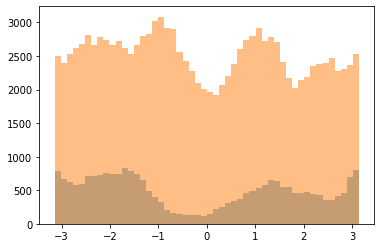

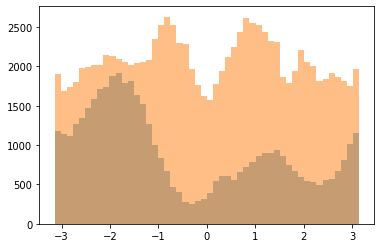

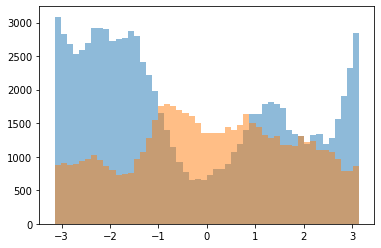

In [47]:
ph = ph_values[0]

for ph in ph_values:
    plt.figure()
    if_density = False
    plt.hist(gs[ph]['chi'][ns[ph] == 0], bins=50, alpha=0.5, density=if_density)[2]
    plt.hist(gs[ph]['chi'][ns[ph] == 1], bins=50, alpha=0.5, density=if_density)[2]



**crucial point!**

when you compute the average value of the k-th observable at pH n. i, this is

\begin{equation}
\sum_j w_{ij} \langle g_k(x) \rangle_{P_j}
\end{equation}

so you put together the values of the k-th observable at given protonation state $P_j$ independently on which simulation at constant pH they come from 

In [ ]:
for ph in ns.keys(): ns[ph] = np.array(ns[ph])

unique_ns = []
for ph in ns.keys(): unique_ns.append(np.unique(ns[ph]))
unique_ns = np.unique(np.array(unique_ns))

unique_ns

Array([0, 1], dtype=int64)

In [72]:
my_gs = {}

for ph in ph_values:
    my_vals = np.array(gs[ph][['chi', 'eRMSD']])
    for n in unique_ns:
        my_gs[n].extend(my_vals[ns[ph] == n])


TypeError: unhashable type: 'jaxlib.xla_extension.ArrayImpl'

In [ ]:
new_gs = {}

# here we have only ns == 0 or ns == 1
for ph in ph_values:
    new_gs['chi'].append(gs[ph]['chi'][ns[ph] == 0])

